In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm

In [3]:
import requests

In [4]:
with open('token.txt', 'r') as f:
    API_TOKEN = f.readlines()[0][:-1]

In [5]:
import berserk

session = berserk.TokenSession(API_TOKEN)
client = berserk.Client(session=session)

In [6]:
berserk.enums.PerfType.BLITZ

'blitz'

In [7]:
def color2bool(color):
    if color == 'white':
        return True
    else:
        return False

def bool2color(b):
    if b:
        return 'white'
    else:
        return 'black'

def flip_color(color):
    if color == 'white':
        return 'black'
    else:
        return 'white'

In [8]:
def my_color(playes_data):
    if playes_data['white']['user']['name'] == 'menisadi':
        return 'white'
    else:
        return 'black'

In [9]:
def opponent_name(playes_data):
    return playes_data[flip_color(my_color(playes_data))]['user']['name']

In [10]:
games = client.games.export_by_player(username='menisadi', perf_type='blitz', 
                                          rated=True, analysed=True, opening=True, 
                                          evals=True)

## One game

In [57]:
first_game = next(games)

In [155]:
playes = first_game['players']

meni_color = my_color(playes)

my_rating = first_game['players'][meni_color]['rating']
opponent_rating = first_game['players'][flip_color(meni_color)]['rating']
opponent = opponent_name(first_game['players'])

time = first_game['createdAt']

termination = first_game['status']

winner = first_game['winner']
did_i_win = winner == meni_color

openning = first_game['opening']['name']

moves = first_game['moves']
game_length = len(moves.split(' '))

my_accuracy = first_game['players'][meni_color]['analysis']['acpl']
opponent_accuracy = first_game['players'][flip_color(meni_color)]['analysis']['acpl']

In [157]:
new_row = pd.DataFrame([{
        'time': time,
        'opponent_name': opponent,
        'my_rating': my_rating,
        'my_color': meni_color,
        'result': winner,
        'did_I_win': did_i_win, 
        'termination_type': termination,
        'length_of_game': game_length,
        'my_average_centripawn_loss': my_accuracy,
        'opponent_average_centripawn_loss': opponent_accuracy
}])

## And now we loop

In [11]:
df = pd.DataFrame(
    columns=['time', 'opponent_name', 'my_rating', 'my_color', 
             'result', 'termination_type', 'length_of_game', 
             'my_acpl', 'opponent_acpl', 
             'my_blunders', 'opponent_blunders',
             'opening'])

In [12]:
for game in games:

    playes = game['players']

    meni_color = my_color(playes)
    my_rating = game['players'][meni_color]['rating']
    opponent_rating = game['players'][flip_color(meni_color)]['rating']
    opponent = opponent_name(game['players'])
    
    time = game['createdAt']
    termination = game['status']
    try:
        winner = game['winner']
    except:
        windder = 'draw'
    did_i_win = winner == meni_color
    opening = game['opening']['name']
    moves = game['moves']
    game_length = len(moves.split(' '))
    my_accuracy = game['players'][meni_color]['analysis']['acpl']
    opponent_accuracy = game['players'][flip_color(meni_color)]['analysis']['acpl']
    my_blunders = game['players'][meni_color]['analysis']['blunder']
    opponent_blunders = game['players'][flip_color(meni_color)]['analysis']['blunder']
    new_row = pd.DataFrame([{
            'time': time,
            'opponent_name': opponent,
            'my_rating': my_rating,
            'my_color': meni_color,
            'opening': opening,
            'result': winner,
            'did_I_win': did_i_win, 
            'termination_type': termination,
            'length_of_game': game_length,
            'my_acpl': my_accuracy,
            'opponent_acpl': opponent_accuracy,
            'my_blunders': my_blunders, 
            'opponent_blunders': opponent_blunders,
    }])

    df = pd.concat([df, new_row])

print('Done')

Done


In [13]:
df = df.sort_values(by='time')
df = df.reset_index().drop('index', axis=1)

In [14]:
df['opening_core'] = df['opening'].apply(lambda o: o.split(':')[0])

In [30]:
openings_df = df.groupby(['opening_core', 'my_color'])['did_I_win'].agg(['mean', 'count']).sort_values(by='count', ascending=False)

In [31]:
openings_df[openings_df['count'] > 5].rename(columns={'mean': 'win_rate', 'count': 'games'})

win_rate  games
opening_core            my_color                 
Caro-Kann Defense       black     0.489130     92
Queen's Gambit Declined white     0.662338     77
Queen's Gambit Accepted white     0.500000     18
Slav Defense            white     0.714286     14
Queen's Pawn Game       black     0.500000     14
Englund Gambit Complex  white     0.384615     13
King's Indian Defense   white     0.272727     11
                        black     0.300000     10
Englund Gambit          white     0.777778      9
Indian Defense          black     0.875000      8
Slav Defense            black     0.428571      7
Sicilian Defense        black     0.571429      7
Indian Defense          white     0.500000      6
Queen's Pawn Game       white     0.500000      6

In [17]:
df['total_acpl'] = df['my_acpl'] + df['opponent_acpl']

In [18]:
df['total_blunders'] = df['my_blunders'] + df['opponent_blunders']

In [19]:
df[
['opponent_name', 'my_rating', 'total_blunders',
 'termination_type', 'did_I_win',  'length_of_game',
 'total_acpl', 'my_acpl', 'opponent_acpl']
].sort_values(by=[
    'total_acpl', 'total_blunders', 'my_acpl', 'opponent_acpl', 'length_of_game'
]).head(20)

,opponent_name,my_rating,total_blunders,termination_type,did_I_win,length_of_game,total_acpl,my_acpl,opponent_acpl
73,felipevgalisteo,1409,2,mate,True,156,26,8,18
365,HaFu5,1461,0,resign,True,12,28,12,16
246,tikam1976,1414,0,outoftime,True,54,31,14,17
243,rafe3,1407,2,mate,False,157,37,23,14
19,Andreas1010,885,1,resign,True,51,45,4,41
206,kapvj,1414,2,mate,True,146,45,16,29
60,szmik,1239,1,outoftime,True,28,47,7,40
207,Akumed,1426,1,resign,True,30,48,2,46
48,Angelina15,1214,1,resign,True,35,48,4,44
187,joskopet,1459,3,resign,False,125,49,32,17


In [20]:
df = df.infer_objects()

In [24]:
# df.to_parquet('analyzed.parquet')

In [29]:
df.groupby('opening_core')['my_acpl'].agg(['min', 'max', 'count', 'mean']).sort_values(by='count', ascending=False).head()

,min,max,count,mean
opening_core,,,,
Caro-Kann Defense,2,258,93,64.483871
Queen's Gambit Declined,4,199,78,68.897436
Slav Defense,4,173,21,59.333333
King's Indian Defense,33,236,21,90.095238
Queen's Pawn Game,15,140,20,66.100000


<Axes: xlabel='my_acpl', ylabel='opponent_acpl'>

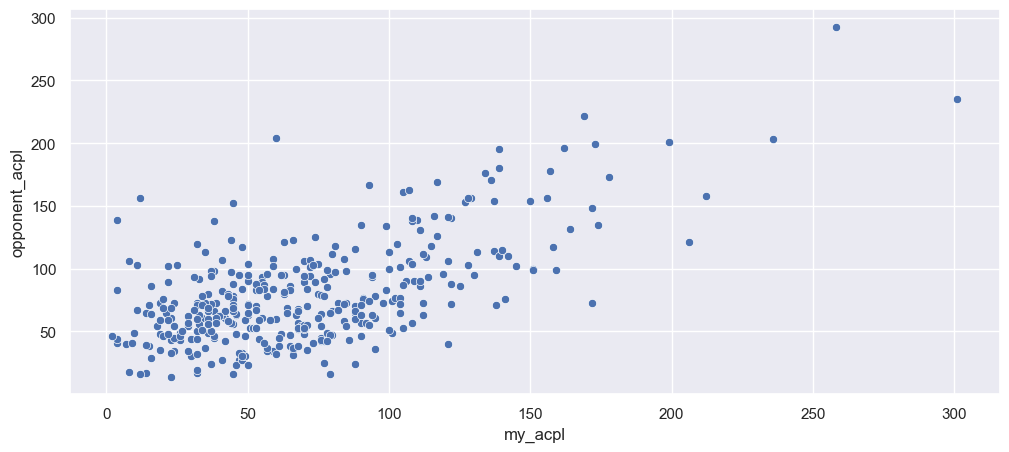

In [33]:
sns.scatterplot(data=df, x='my_acpl', y='opponent_acpl')

<Axes: xlabel='length_of_game', ylabel='total_acpl'>

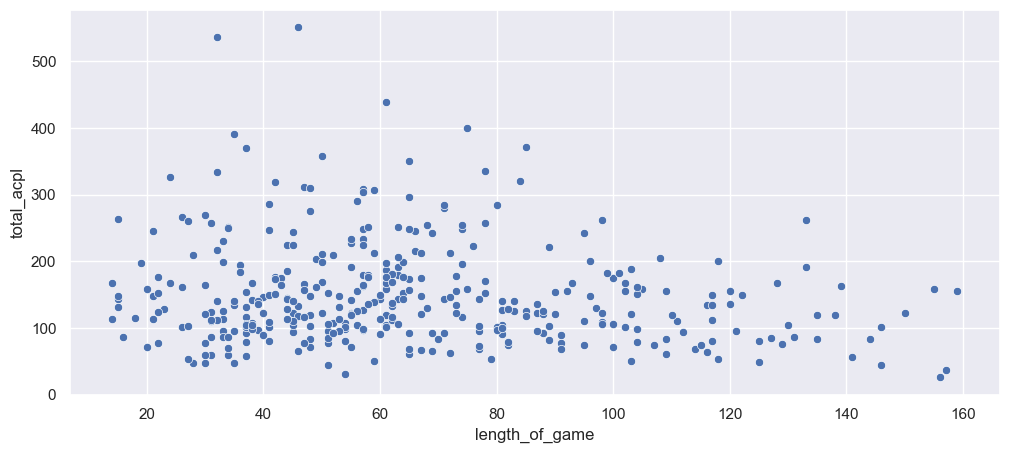

In [128]:
sns.scatterplot(data=df, x='length_of_game', y='total_acpl')

<Axes: xlabel='my_rating', ylabel='total_acpl'>

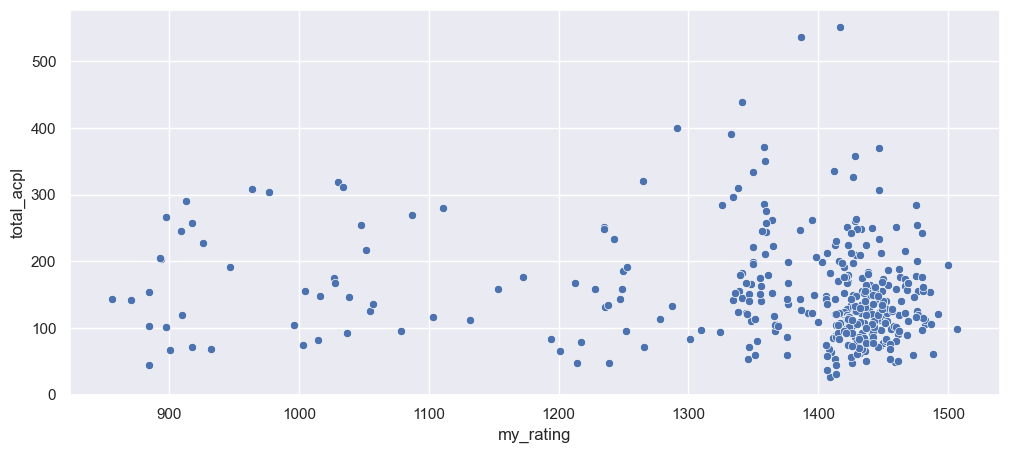

In [133]:
sns.scatterplot(data=df, x='my_rating', y='total_acpl')

Text(0.5, 1.0, 'My ACPL')

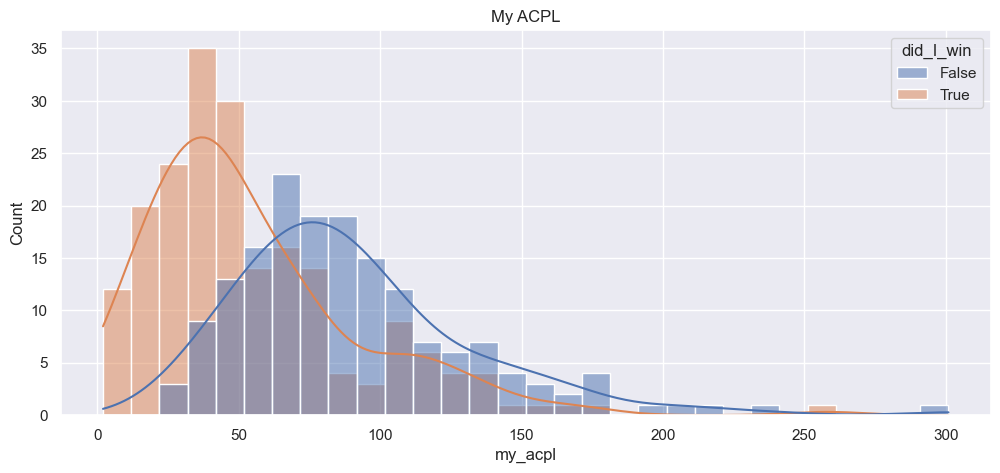

In [40]:
sns.histplot(data=df, x='my_acpl', hue='did_I_win', bins=30, kde=True)
plt.title('My ACPL')

Text(0.5, 1.0, 'Opponent ACPL')

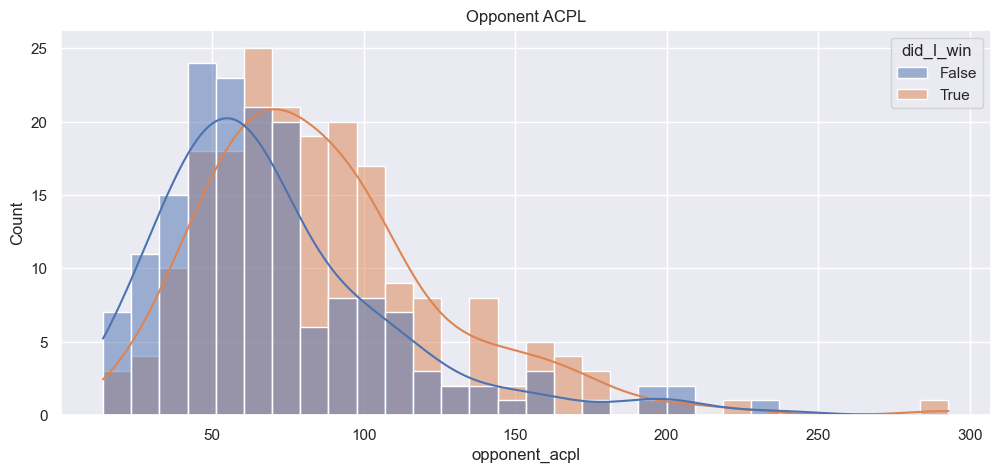

In [42]:
sns.histplot(data=df, x='opponent_acpl', hue='did_I_win', bins=30, kde=True)
plt.title('Opponent ACPL')

Text(0.5, 1.0, 'Total ACPL')

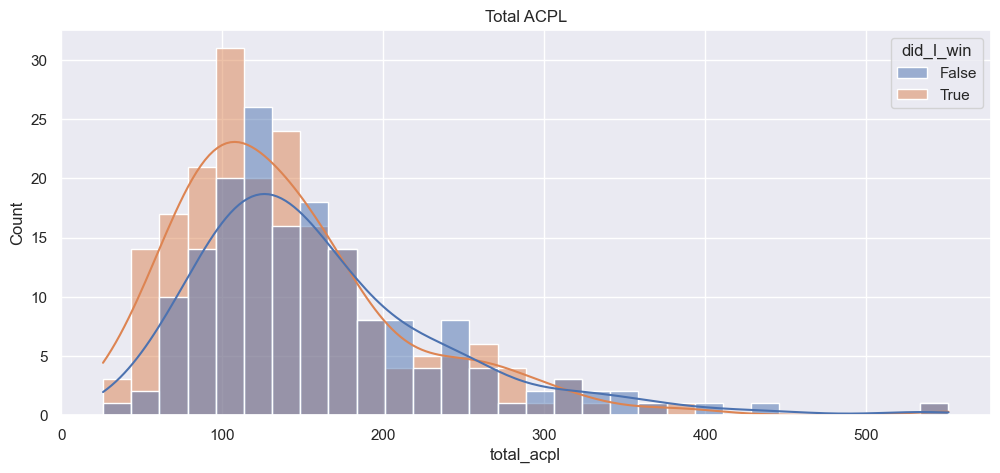

In [43]:
sns.histplot(data=df, x='total_acpl', hue='did_I_win', bins=30, kde=True)
plt.title('Total ACPL')

Index(['Caro-Kann Defense', 'Queen's Gambit Declined', 'Slav Defense',
       'King's Indian Defense', 'Queen's Pawn Game'],
      dtype='object', name='opening_core')

<Axes: xlabel='opening_core', ylabel='my_acpl'>

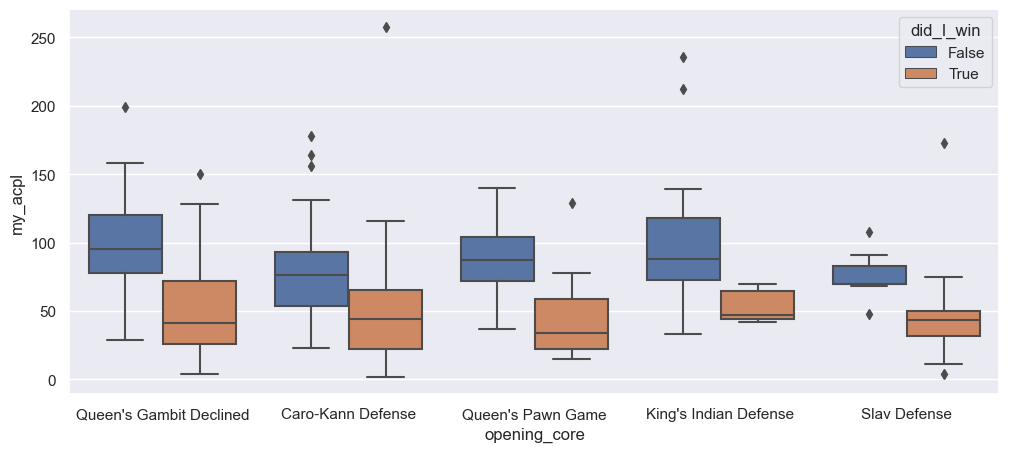

In [52]:
sns.boxplot(data=df[df['opening_core'].isin(df['opening_core'].value_counts().head().index)], 
            x='opening_core', y='my_acpl', hue='did_I_win')

<Axes: xlabel='opening_core', ylabel='total_acpl'>

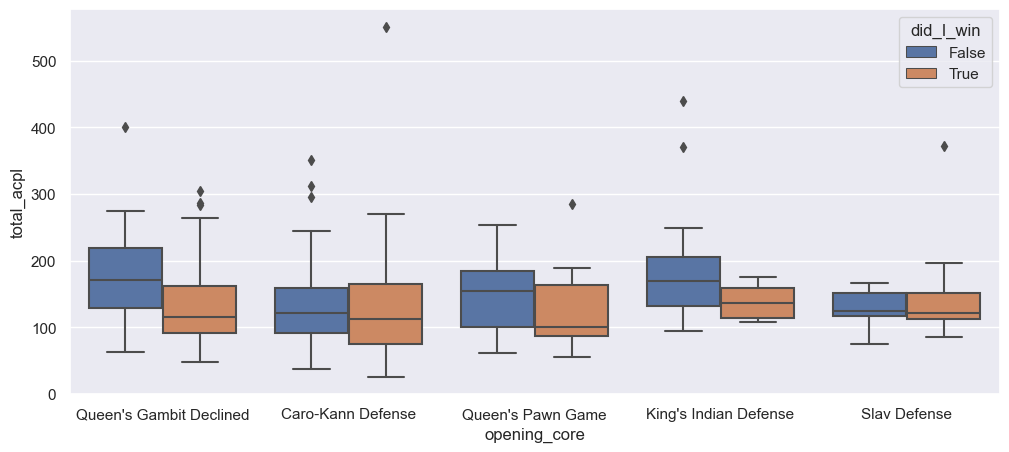

In [53]:
sns.boxplot(data=df[df['opening_core'].isin(df['opening_core'].value_counts().head().index)], 
            x='opening_core', y='total_acpl', hue='did_I_win')

<Axes: xlabel='opening_core', ylabel='my_acpl'>

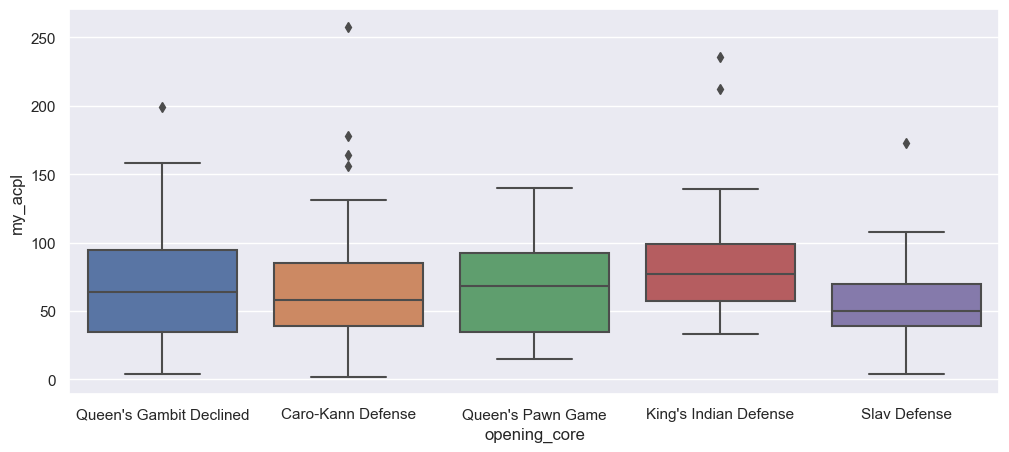

In [55]:
sns.boxplot(data=df[df['opening_core'].isin(df['opening_core'].value_counts().head().index)], 
            x='opening_core', y='my_acpl')

<Axes: xlabel='total_blunders', ylabel='count'>

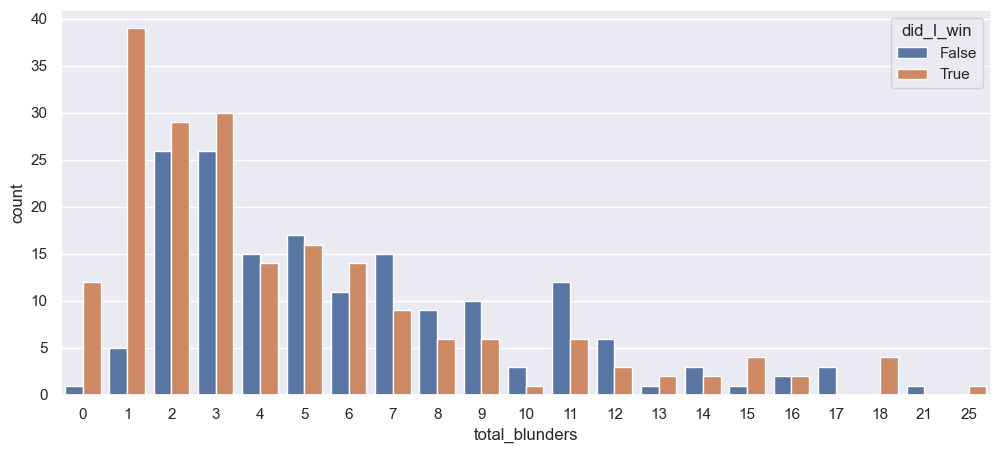

In [56]:
sns.countplot(data=df, x='total_blunders', hue='did_I_win')

<Axes: xlabel='did_I_win', ylabel='total_blunders'>

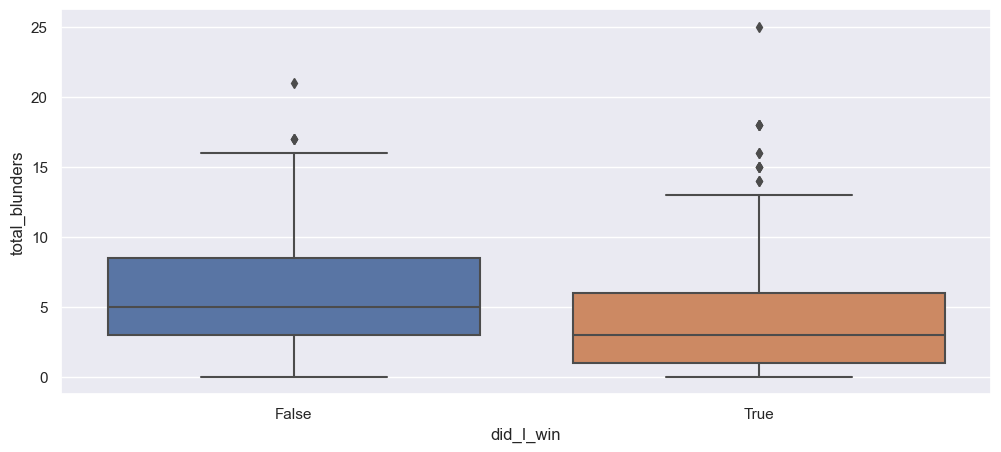

In [76]:
sns.boxplot(data=df, x='did_I_win', y='total_blunders')

In [70]:
df.loc[df['total_blunders']==1, 'did_I_win'].value_counts()

did_I_win
True     39
False     5
Name: count, dtype: int64

In [69]:
df.loc[df['total_blunders']==1, ['did_I_win', 'termination_type']].value_counts()

did_I_win  termination_type
True       resign              26
           mate                 9
False      mate                 3
True       outoftime            3
False      resign               2
True       timeout              1
Name: count, dtype: int64